In [1]:
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from glob import glob
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

ERROR 1: PROJ: proj_create_from_database: Open of /home/b/b381815/miniconda3/envs/py/share/proj failed


In [2]:
def plot_map(ax, da, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cbar_kwargs'] = {'pad': .01}
        
    # proj = ccrs.PlateCarree()
    # fig, ax = plt.subplots(subplot_kw={'projection': proj}, figsize=(9, 4))
    map_ = da.plot.pcolormesh(ax=ax, **kwargs)
        
    ax.coastlines()
    # ax.set_xticks([-180, -120, -60, 0, 60, 120, 180])
    # ax.set_yticks([-90, -60, -30, 0, 30, 60, 90])
    # ax.xaxis.set_major_formatter(LongitudeFormatter())
    # ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title('')
    map_.colorbar.set_label('')
    
    # fig.tight_layout()

    return ax, map_

def area_weighted_mean(da):   
    cell_area = np.cos(np.deg2rad(da['lat']))
    return da.weighted(cell_area).mean(dim=('lat', 'lon'), keep_attrs=True)


In [3]:
path = '/work/uc1275/LukasBrunner/data/etccdi_cdo'

In [4]:
etccdi_indices = [
    'cdd',  'cwd', 'prcptot', 'r10mm', 'r20mm', 'r95p', 'r99p', 'rx1day', 'rx5day', 'sdii',  # pr-based 
    'csdi', 'fd', 'id', 'tn10p', 'tn90p', 'tnn', 'tnx', 'tr',  # tasmin-based
    'su', 'tx10p', 'tx90p', 'txn', 'txx', 'wsdi',  # tasmax-based
    'dtr',  # tasmin & tasmax
    'gsl',  # tas
]
# len(etccdi_indices)

## Load cdo data

In [5]:
dict_cdo = {}
dict_freq = {}

fn_pattern = '{index}ETCCDI_*.nc'
for index in etccdi_indices:
    # print(index)
    fns = glob(os.path.join(path, 'cdo_test', fn_pattern.format(index=index)))
    if len(fns) != 1:
        print(fns)
        raise ValueError
    da = xr.open_dataset(fns[0], decode_timedelta=False)[f'{index}ETCCDI']
    if da.attrs['units'] == 'kg m-2 s-1':
        da.values *= 86400
        da.attrs['units'] = 'mm/day'
    if da.attrs['units'] == 'K':
        if index != 'dtr':
            da.values -= 273.15
        da.attrs['units'] = 'degC'
        
    freq = 'MON' if 'mon' in fns[0] else 'ANN'

    dict_cdo[index] = da
    dict_freq[index] = freq
    

## Load ClimDexCalc2 data

In [6]:
dict_cdc = {}

fn_pattern = '{index}_{freq}_*.nc'
for index in dict_cdo.keys():
    # print(index)
    fns = glob(os.path.join(path, 'climdexcalc2_test', fn_pattern.format(index=index, freq=dict_freq[index].upper())))
    if len(fns) != 1:
        print(fns)
        raise ValueError
    da = xr.open_dataset(fns[0], decode_timedelta=False)[f'{index}']

    dict_cdc[index] = da
    

## Plot maps: cdo

In [7]:
period = slice('1995', '2014')

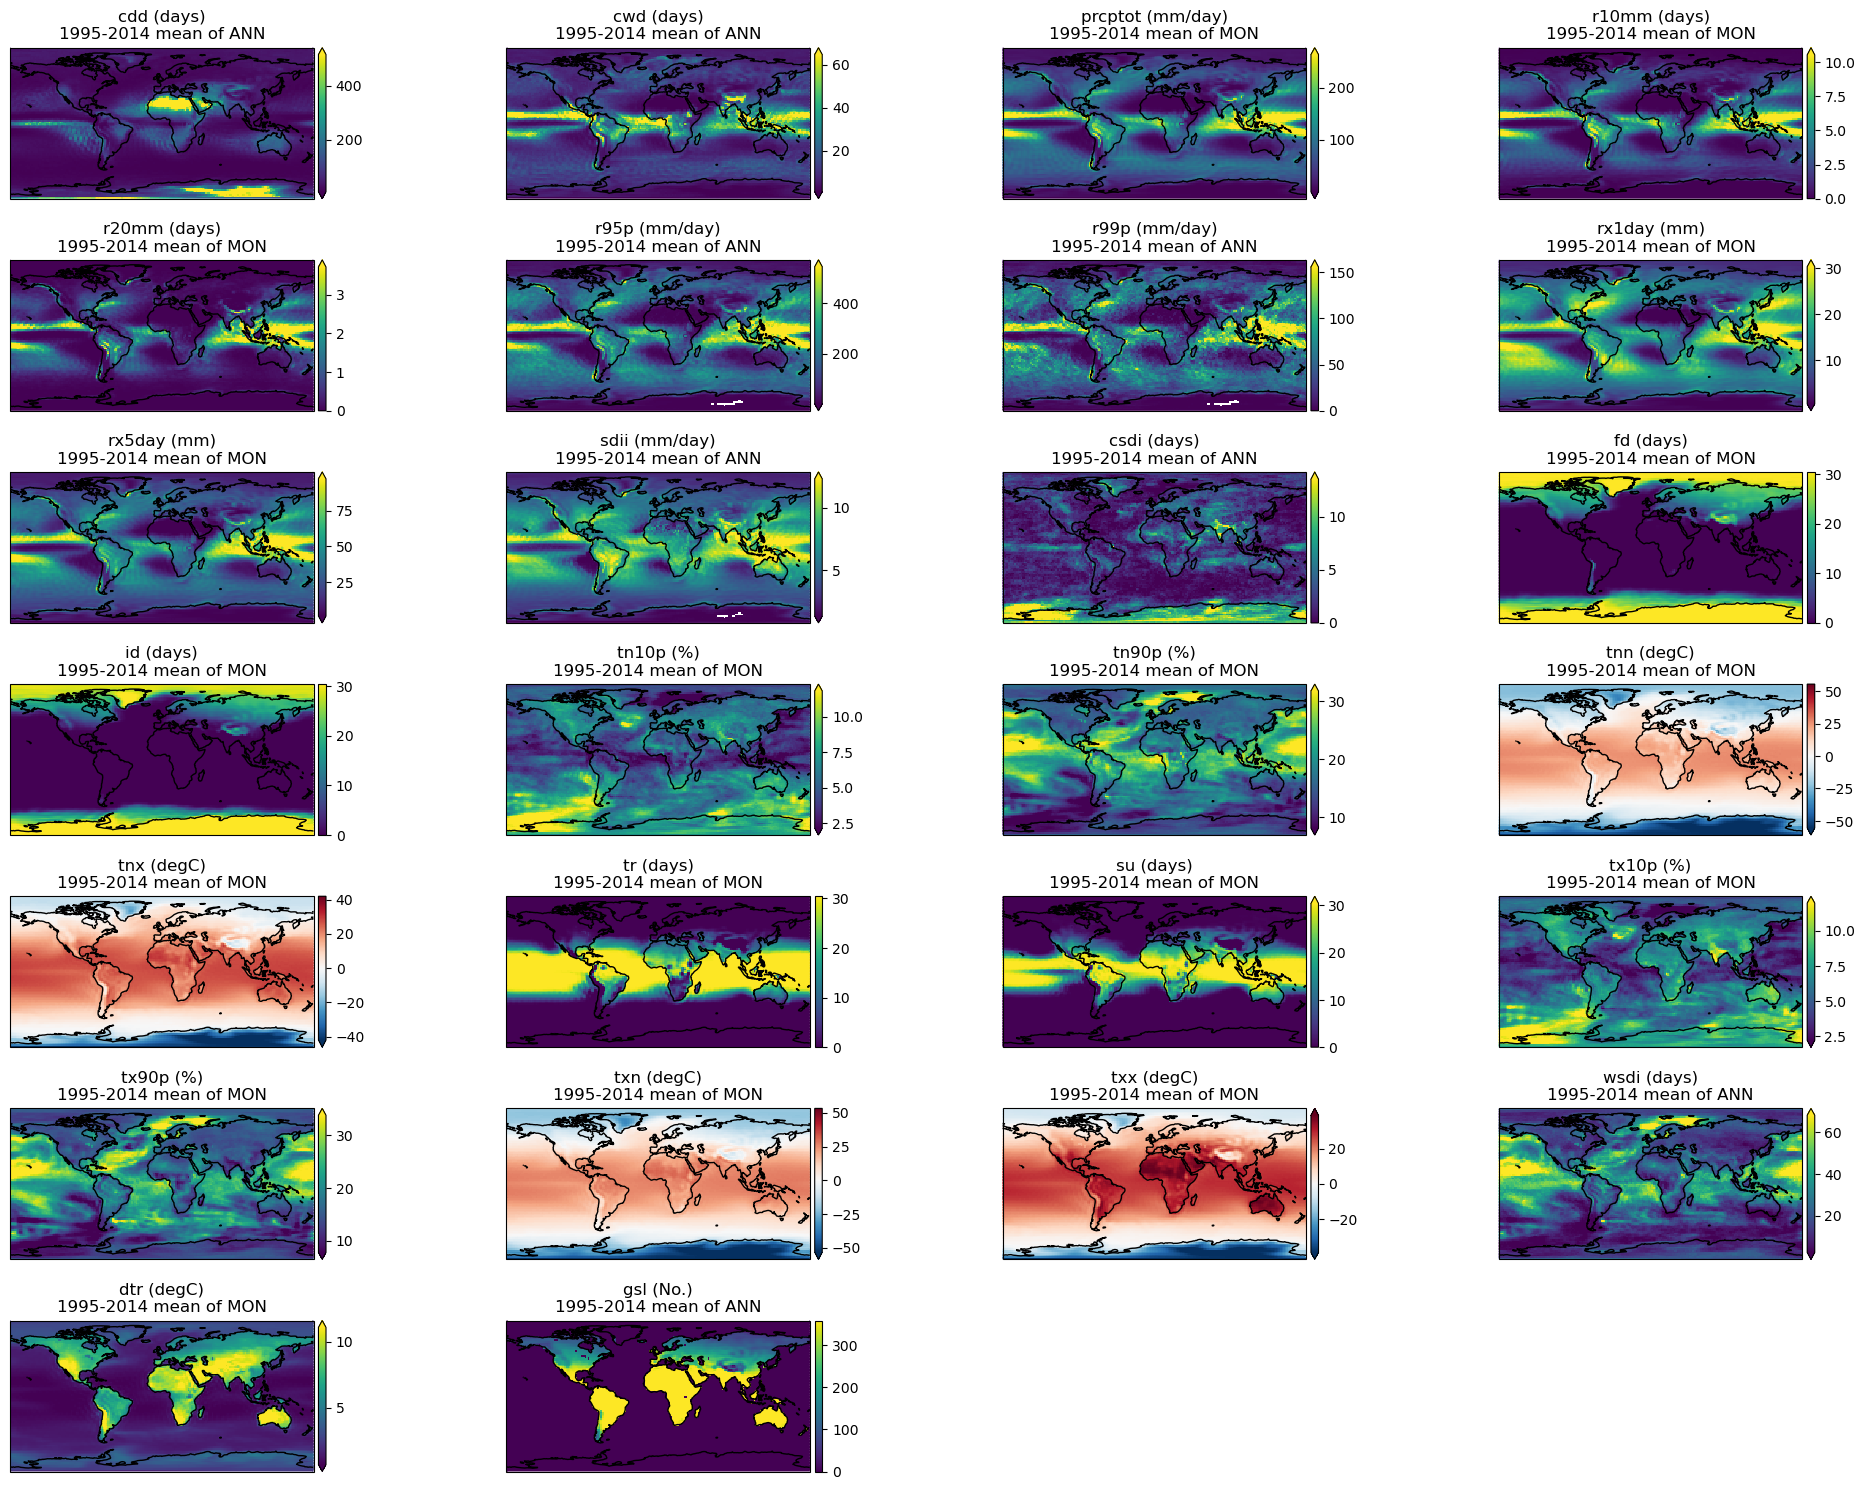

In [8]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(20, 15))

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdo[index]
    ax = axes.ravel()[idx]
    da = da.sel(time=period).mean('time', keep_attrs=True)   
    plot_map(ax, da, robust=True)
    ax.set_title('{} ({})\n{}-{} mean of {}'.format(
        index, da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Plot maps: cdo - ClimDexCalc2

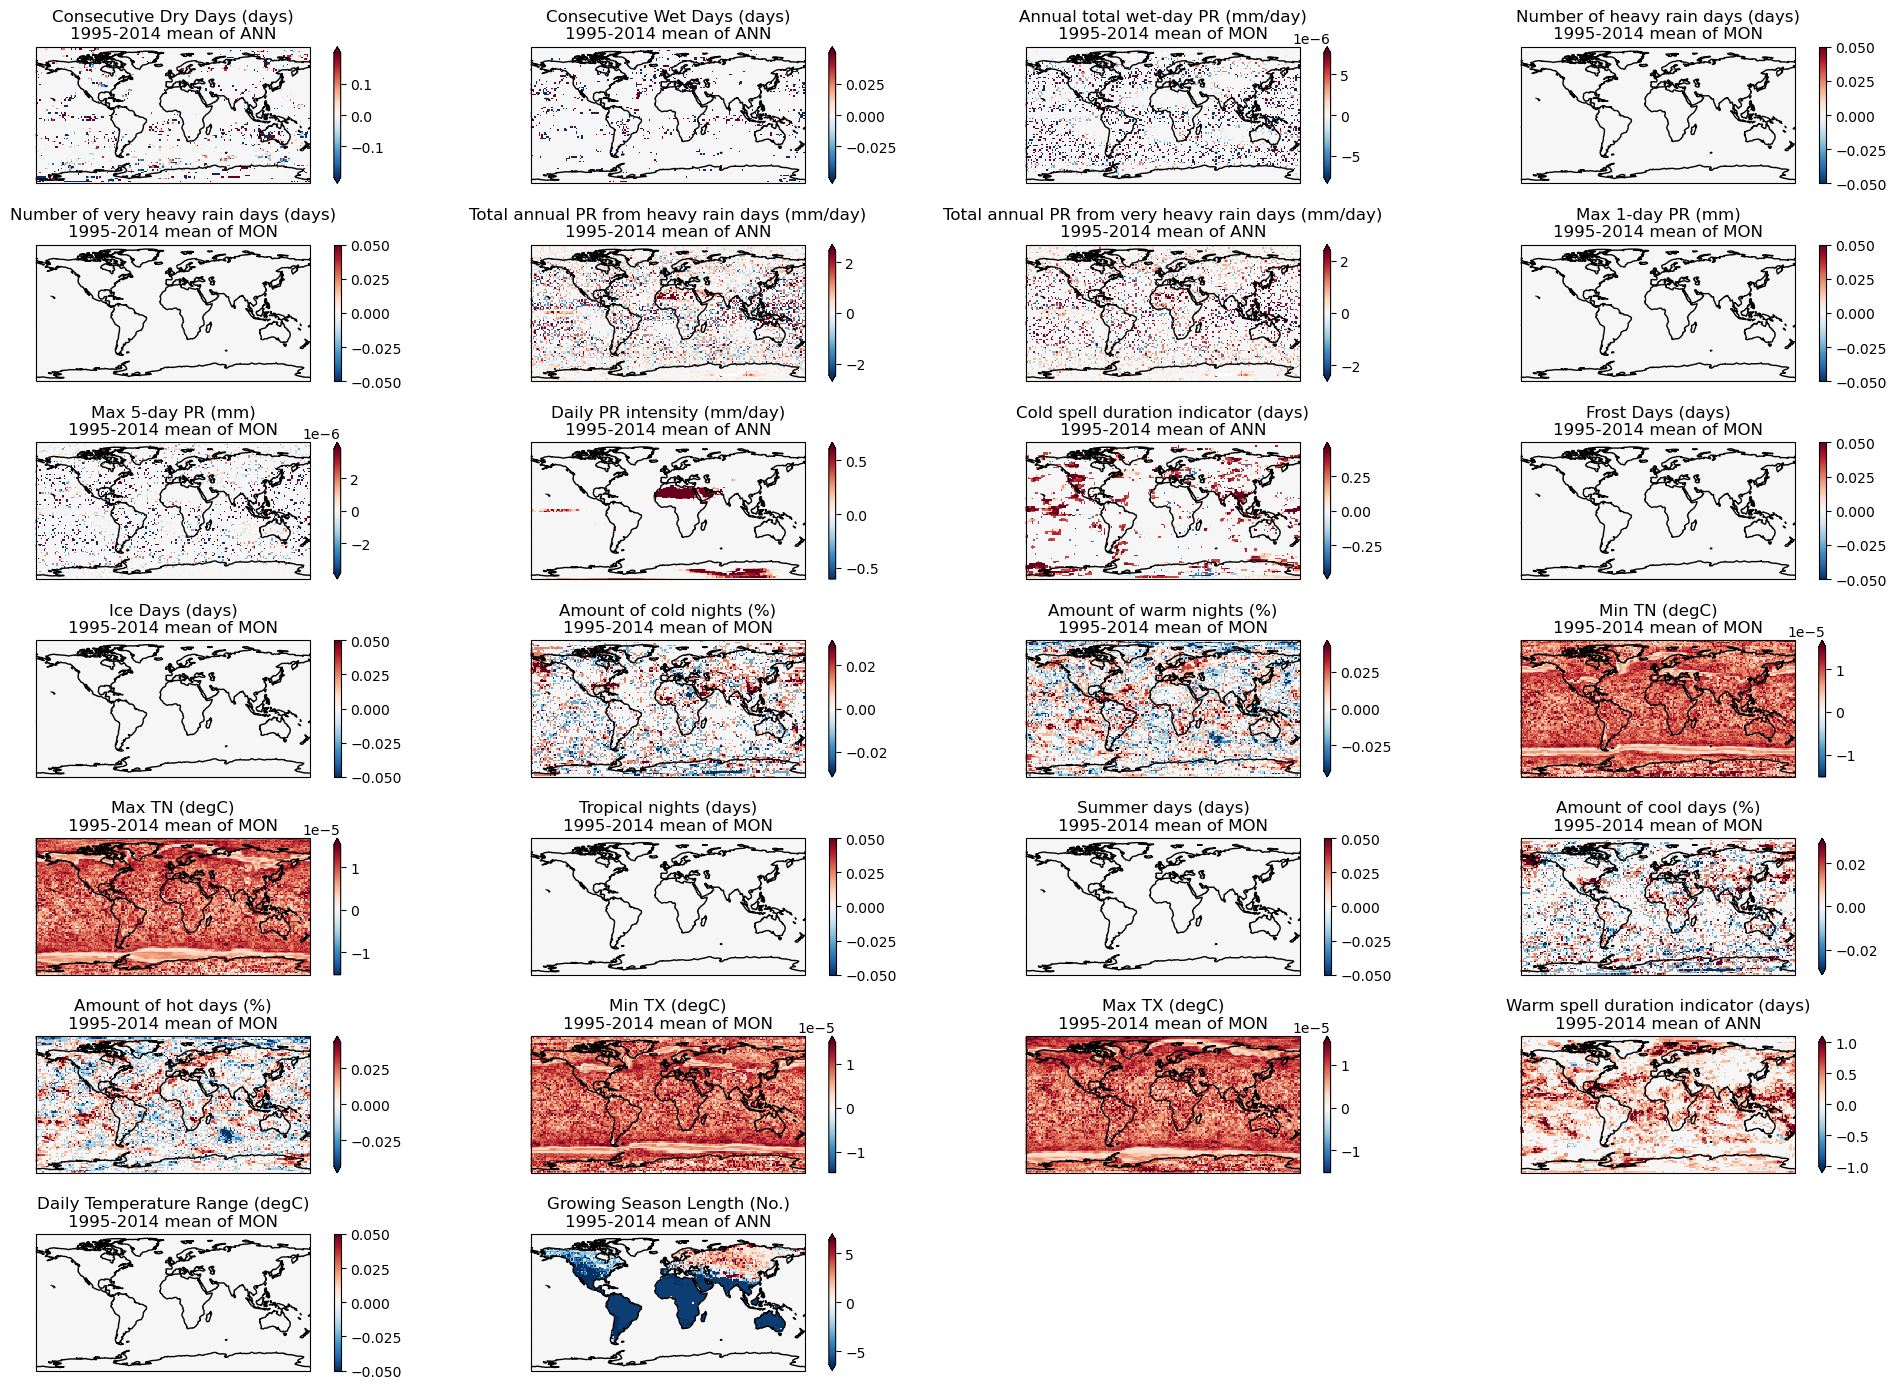

In [9]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(20, 14))

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdo[index]
    ref = dict_cdc[index]
    
    da = da.sel(time=period).mean('time', keep_attrs=True)
    ref = ref.sel(time=period).mean('time', keep_attrs=True)
    
    ax = axes.ravel()[idx]

    if index == 'gsl':
        plot_map(ax, (da - ref).where(da!=0, 0), robust=True, cmap='RdBu_r', center=0)
    else:
        plot_map(ax, da - ref, robust=True, cmap='RdBu_r', center=0)
    # ax.set_title('{} ({})'.format(index, da.attrs['units']))
    ax.set_title('{} ({})\n{}-{} mean of {}'.format(
        ref.attrs.get('long_name', index), da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Plot maps: ClimDexCalc2

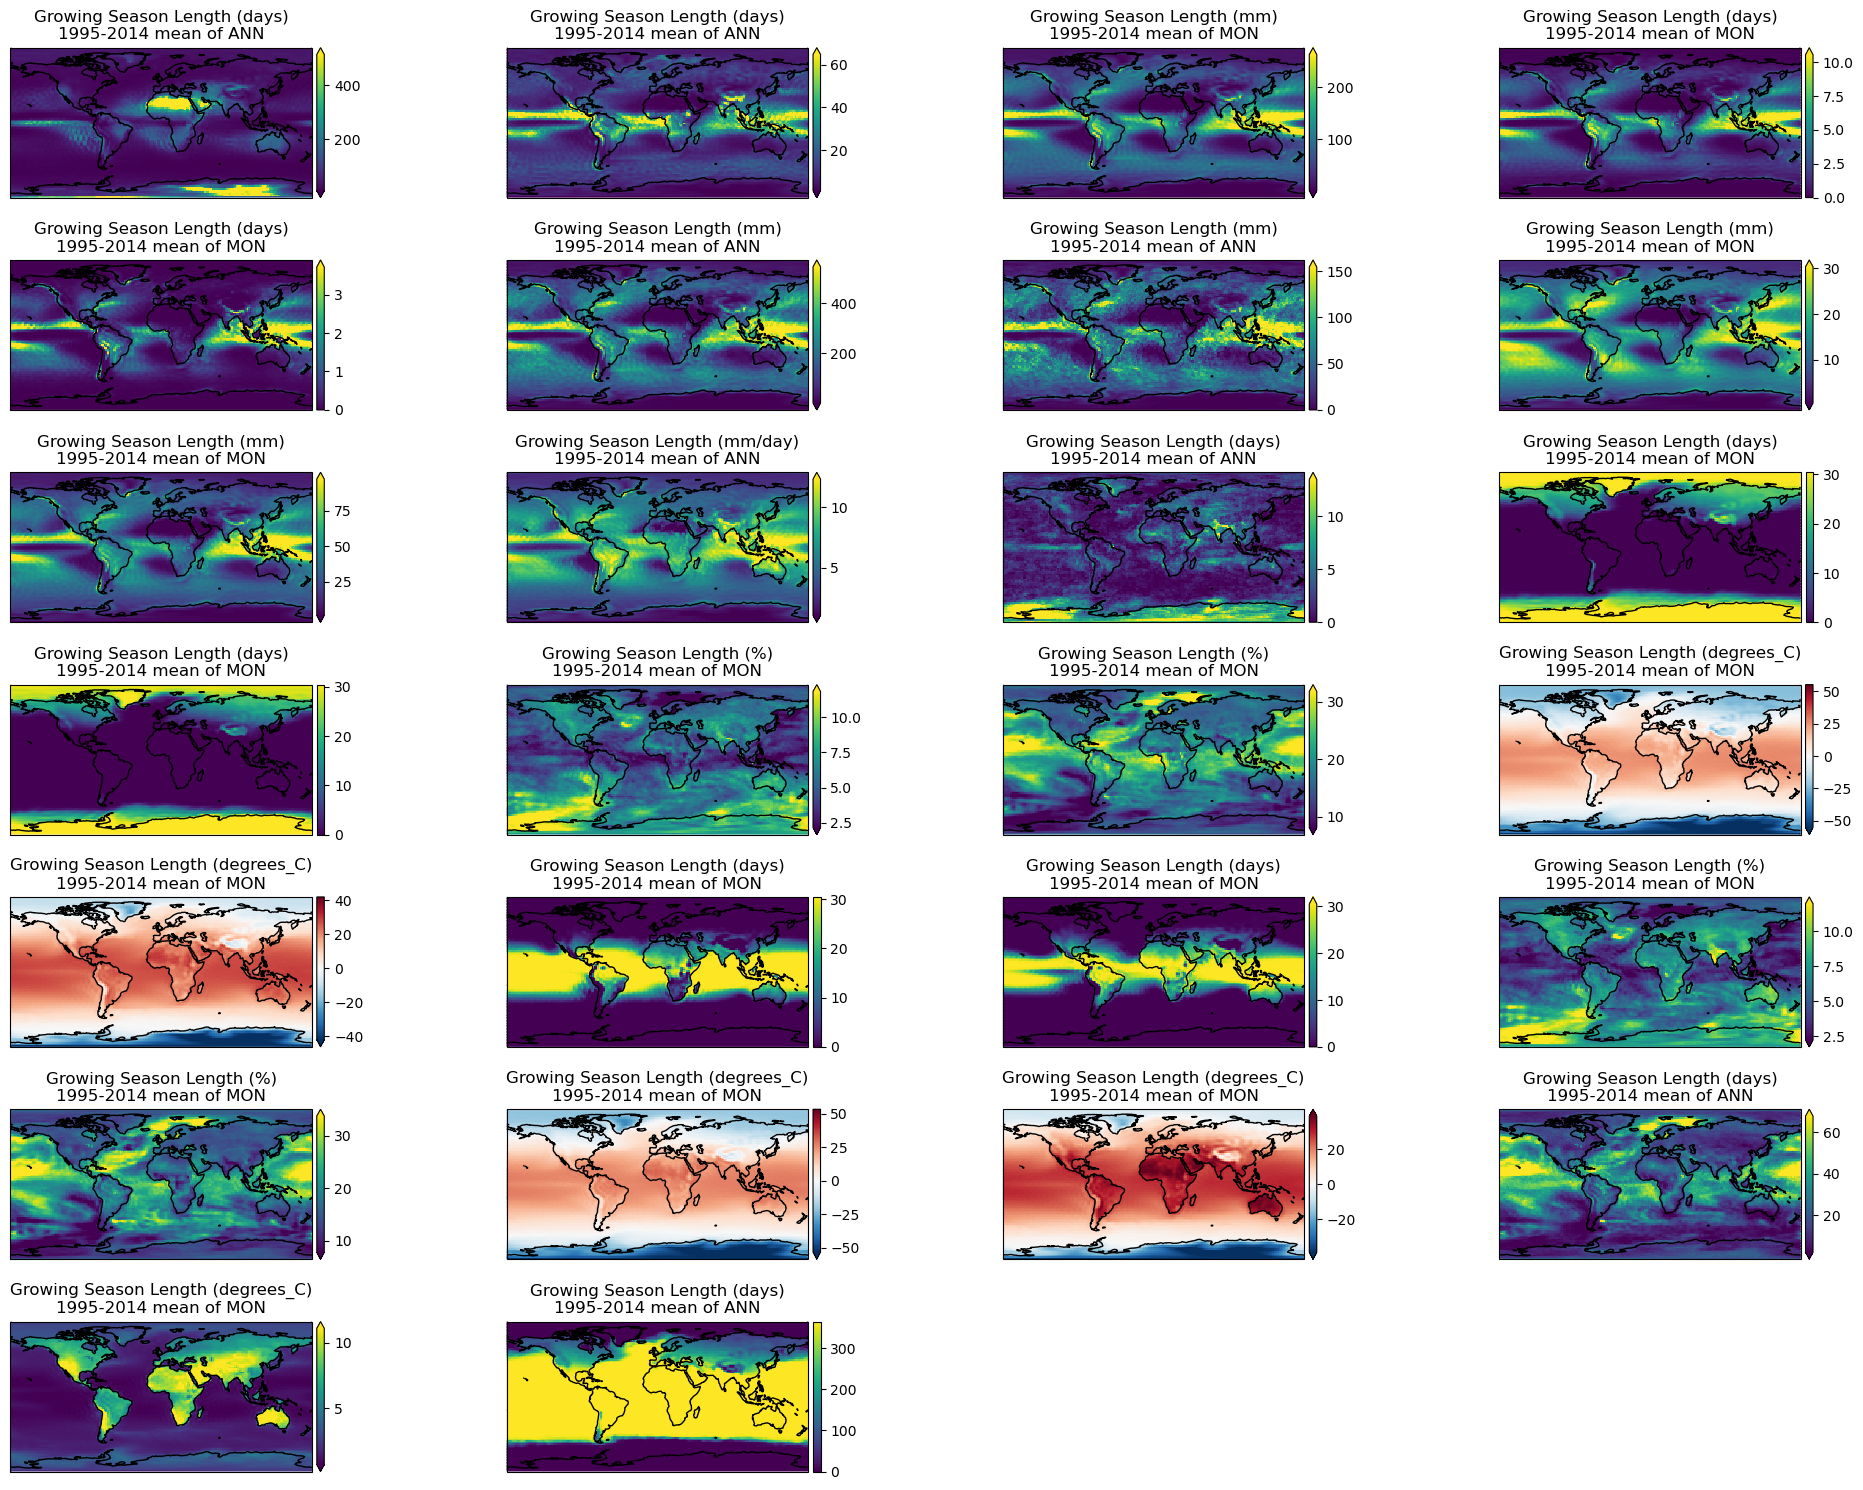

In [10]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(7, 4, subplot_kw={'projection': proj}, figsize=(20, 15))

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdc[index]
    ax = axes.ravel()[idx]
    da = da.sel(time=period).mean('time', keep_attrs=True)
    plot_map(ax, da, robust=True)
    ax.set_title('{} ({})\n{}-{} mean of {}'.format(
        ref.attrs.get('long_name', index), da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))
    
idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1

fig.tight_layout()

## Lineplots: cdo

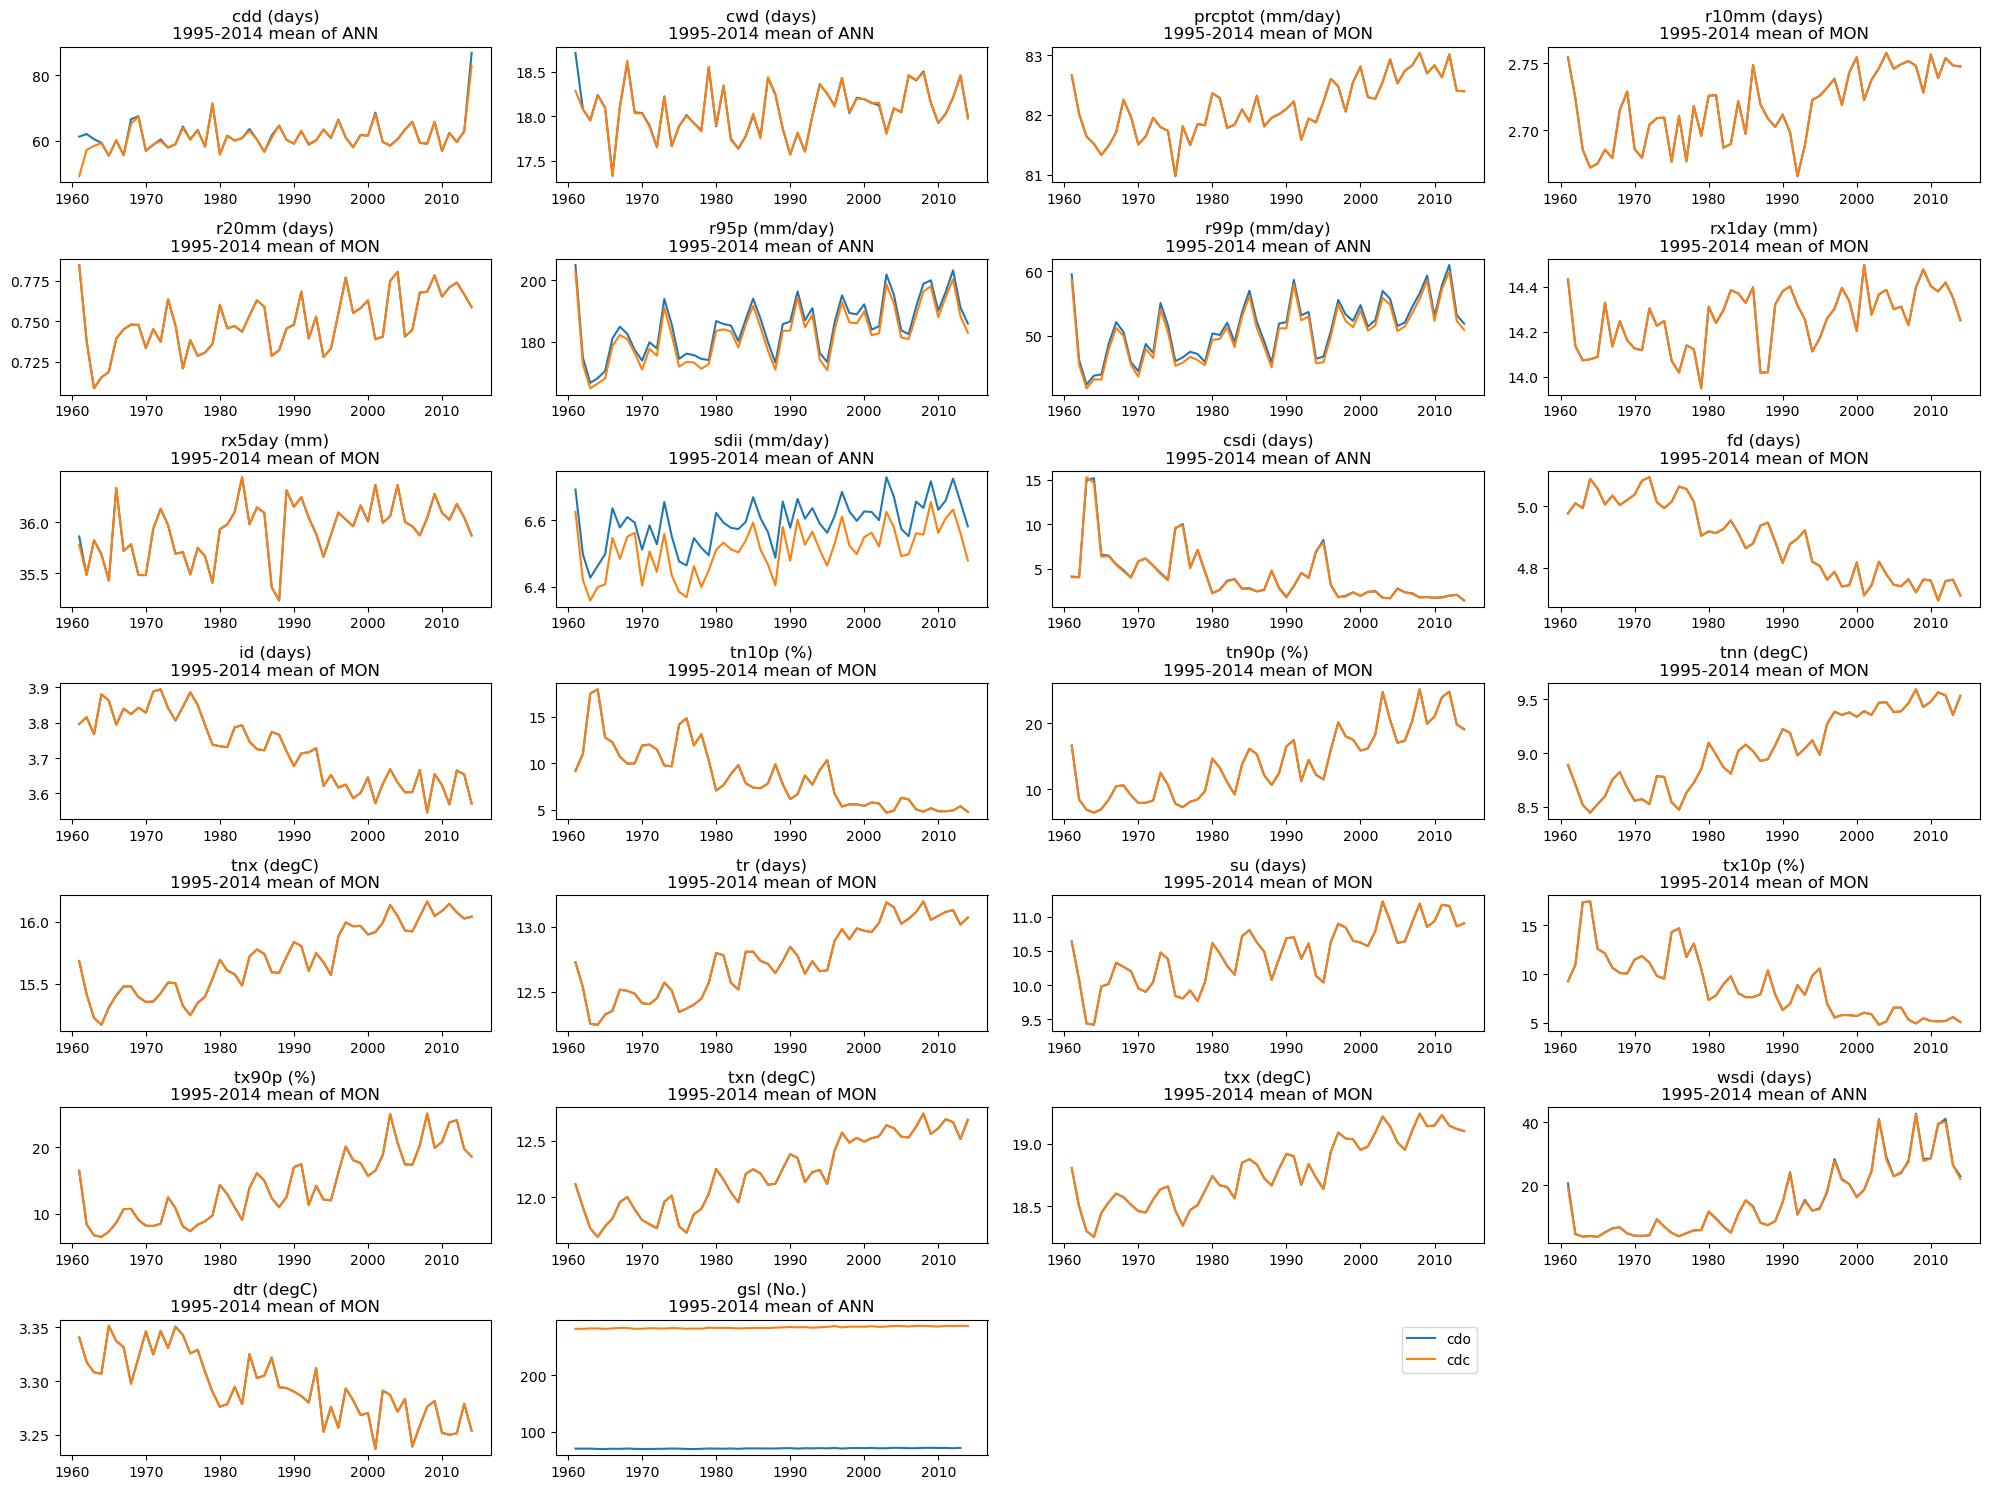

In [11]:
fig, axes = plt.subplots(7, 4, figsize=(20, 15))

for idx, index in enumerate(dict_cdo.keys()):
    da = dict_cdo[index]
    ref = dict_cdc[index]

    ref = area_weighted_mean(ref.sel(time=slice('1961', '2014')).groupby('time.year').mean())
    da = area_weighted_mean(da.sel(time=slice('1961', '2014')).groupby('time.year').mean())
    
    ax = axes.ravel()[idx]
    
    hh1, = ax.plot(da['year'], da, label='cdo')
    hh2, = ax.plot(ref['year'], ref, label='cdc')
    
    ax.set_title('{} ({})\n{}-{} mean of {}'.format(
        index, da.attrs['units'],
        period.start, period.stop, dict_freq[index],
    ))

idx += 1
ax = axes.ravel()[idx]
ax.axis('off')
ax.legend(handles=[hh1, hh2])

idx += 1
while idx < len(axes.ravel()):
    axes.ravel()[idx].set_visible(False)
    idx += 1
    
fig.tight_layout() 